In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from extract_features import get_features
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [2]:
semi = True

if semi:
    features = get_features()

    features_torch = []
    class_ids_torch = []

    # extract features and make tensors
    for feature in features:
        feature_tensor = feature[0].detach().cpu()
        label = feature[1]
        class_id = feature[2]

        features_torch.append(feature_tensor)
        class_ids_torch.append(torch.as_tensor(class_id))

    # stack lists:
    X_data = torch.stack(features_torch)
    y_data = torch.stack(class_ids_torch)
else:
    root_dir = '/caa/Homes01/mburges/viennaup23-hackathon-recycling/backend/data/'
    data_json = json.load(open(root_dir + 'labels.json'))

    features_path = os.path.join(root_dir, 'images')

    features_torch = []
    class_ids_torch = []
    for file in data_json:
        print(file, data_json[file])
        file = file.replace('.jpg', '.npy')
        features = np.load(os.path.join(features_path, file))

        features_torch.append(torch.as_tensor(features))
        class_ids_torch.append(torch.as_tensor(data_json[file]))
    
    # stack lists:
    X_data = torch.stack(features_torch)
    y_data = torch.stack(class_ids_torch)

  0%|          | 0/56 [00:00<?, ?it/s]

/data/mburges/miniconda/envs/SegAny/lib/python3.10/site-packages/transformers/models/owlvit/image_processing_owlvit.py:355: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection`
  warnings.warn(


In [3]:
class FloKo(nn.Module):
    def __init__(self):
        super(FloKo, self).__init__()
        self.fc = nn.Linear(768, 50)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(50, 2)
        self.fc4 = nn.Linear(2, torch.stack(class_ids_torch).max()+1)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        intermediate = self.fc3(x)
        x = self.fc4(intermediate)
        x = self.sigmoid(x)

        return x, intermediate

model = FloKo()

print(summary(model, (768,)))

Layer (type:depth-idx)                   Output Shape              Param #
FloKo                                    [3]                       --
├─Linear: 1-1                            [50]                      38,450
├─ReLU: 1-2                              [50]                      --
├─Linear: 1-3                            [2]                       102
├─Linear: 1-4                            [3]                       9
├─Sigmoid: 1-5                           [3]                       --
Total params: 38,561
Trainable params: 38,561
Non-trainable params: 0
Total mult-adds (M): 1.92
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.15
Estimated Total Size (MB): 0.16


In [4]:
# Training loop
num_epochs = 100
model.to("cuda")

# split data into train and test
X_train = X_data[:int(len(X_data)*0.8)]
y_train = y_data[:int(len(y_data)*0.8)]

X_test = X_data[int(len(X_data)*0.8):]
y_test = y_data[int(len(y_data)*0.8):]


# Create a TensorDataset
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
# Create a TensorDataset
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
# Create a DataLoader
batch_size = 10
dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

losses = []
for epoch in trange(num_epochs):
    total_loss = []
    for inputs, targets in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        inputs = inputs.to("cuda")
        targets = targets.to("cuda")

        # encode targets hot one
        targets = torch.nn.functional.one_hot(targets, num_classes=3).float()
        
        # Forward pass
        output, intermediate = model(inputs)
        
        # Compute the loss
        loss = loss_function(output, target=targets)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        total_loss.append(loss.item())
    losses.append(np.mean(total_loss))


  0%|          | 0/100 [00:00<?, ?it/s]

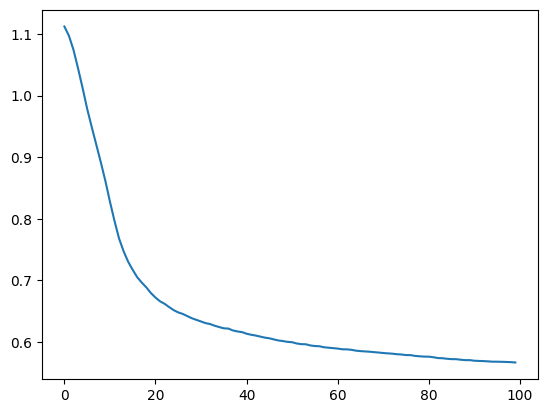

In [5]:
# plot loss
plt.plot(losses)
plt.show()

In [6]:
# run model over dataset and get features

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

model.eval()

features = []
class_ids = []
predictions = []

for inputs, labels in tqdm(test_loader):
    inputs = inputs.cuda()
    outputs, intermediate = model(inputs)
    features.append(intermediate.squeeze().detach().cpu().numpy())
    predictions.append(outputs.squeeze().detach().cpu().numpy())
    class_ids.append(labels.detach().cpu().numpy())

features = np.array(features)
class_ids = np.array(class_ids)
predictions = np.argmax(np.array(predictions), axis=1)

print(features.shape)
print(class_ids.shape)
print(predictions.shape)

  0%|          | 0/48 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
# Get weights of last layer
weights = model.fc4.weight.detach().cpu().numpy()

# plot features and labels in matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title('Labels')
ax1.scatter(features[:, 0], features[:, 1], c=class_ids, cmap='coolwarm')
ax2.set_title('Predictions')
ax2.scatter(features[:, 0], features[:, 1], c=predictions, cmap='coolwarm')
#draw lines of weights

plt.show()